<a href="https://colab.research.google.com/github/thunderhoser/cira_ml_short_course/blob/master/lecture02_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2: Linear and logistic regression

This notebook was used for the CIRA (Cooperative Institute for Research in the Atmosphere) machine-learning short course in Fall 2020.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2020: "Lecture 2: Linear and logistic regression". CIRA (Cooperative Institute for Research in the Atmosphere) machine-learning short course, https://github.com/thunderhoser/cira_ml_short_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical framework for assessing the quality of probability forecasts." *International Journal of Forecasting*, **2**, 285–293, https://doi.org/10.1016/0169-2070(86)90048-8.

Metz, C., 1978: "Basic principles of ROC analysis." *Seminars in Nuclear Medicine*, **8**, 283–298, https://doi.org/10.1016/S0001-2998(78)80014-2.

Roebber, P., 2009: "Visualizing multiple measures of forecast quality." *Weather and Forecasting*, **24**, 601-608, https://doi.org/10.1175/2008WAF2222159.1.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Stachl, C., F. Pargent, S. Hilbert, G. Harari, R. Schoedel, S. Vaid, S. Gosling, and M. Bühner, 2020: "Personality research and assessment in the era of machine learning." *European Journal of Personality*, **Special Issue**, https://doi.org/10.1002/per.2257.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/cira_ml_short_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 393 (delta 14), reused 25 (delta 5), pack-reused 356
Receiving objects: 100% (393/393), 91.19 MiB | 34.48 MiB/s, done.
Resolving deltas: 100% (224/224), done.
running install
running bdist_egg
running egg_info
creating cira_ml_short_course.egg-info
writing cira_ml_short_course.egg-info/PKG-INFO
writing dependency_links to cira_ml_short_course.egg-info/dependency_links.txt
writing requirements to cira_ml_short_course.egg-info/requires.txt
writing top-level names to cira_ml_short_course.egg-info/top_level.txt
writing manifest file 'cira_ml_short_course.egg-info/SOURCES.txt'
writing manifest file 'cira_ml_short_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/cira_ml_short_course
copy

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/cira_ml_short_course/')
sys.path.append('/content/course_repository/cira_ml_short_course/utils/')

In [ ]:
%matplotlib inline
import copy
import os.path
import warnings
import numpy
import keras
from matplotlib import pyplot
from cira_ml_short_course.utils import utils

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATA_DIRECTORY_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'

# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_tabular_data.py

Unzipping file: "data/track_data_ncar_ams_3km_csv_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

- The next cell reads all input data for this notebook into memory.
<br><br>
- **The dataset consists of 41 predictors and one target variable (max future vorticity) for each storm object.**
- A "storm object" is one thunderstorm cell at one time step.
<br><br>

- **This is a tabular dataset** (containing scalar features computed from spatial grids), **rather than an image dataset** (containing the spatial grids themselves).
- **Image data cannot be used for the traditional ML models discussed in this notebook.**
- However, image data can be used by deep-learning models, which are subject of later lectures.

In [ ]:
training_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20100101',
    last_date_string='20141231'
)
validation_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20150101',
    last_date_string='20151231'
)
testing_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20160101',
    last_date_string='20171231'
)

(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_tabular_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_tabular_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_tabular_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# Overfitting

 - You can't talk about machine learning without talking about overfitting.
 - **Overfitting occurs when the model performs well on training data but does not generalize well to new data.**
<br><br>

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/overfitting_schematic.jpg" alt="Overfitting schematic" width="750" /></center>
<center>(Image credit: Figure 2 of Stachl et al. 2020)</center>
<br>

 - **This usually occurs in the following scenarios:**
     - Training set is small
     - Training set includes inappropriate predictors
     - Training set is not representative of the real world
<br><br>
 - **Examples of inappropriate predictors**:
     - Using storm ID to predict tornadoes
     - Using patient ID to predict disease
     - In general, using variables with no physical relationship to the target phenomenon
<br><br>
 - **Examples of non-representative training data**:
     - Different label distributions (*e.g.*, 50% of storms in the training data are tornadic, but $<$ 1% of storms in the real world are tornadic)
     - Different levels of data quality (*e.g.*, train on quality-controlled archive data but apply to messy real-time data)
<br><br>

 - You can mitigate overfitting by not making the above mistakes.
 - **However, these properties** (appropriateness of predictor, representativity of training data, etc.) **are not always clear.**
 - Also, many factors can lead to overfitting, and it is difficult to account for all of them.
 - **Thus, you also need the ability to diagnose overfitting.**
 - **This is usually done by splitting data into 3 partitions: training, validation, and testing.**

# Training, validation, and testing

 - **The role of training data is to adjust model parameters**.  Examples:
   - Weights in linear regression
   - Weights in a neural network
   - Decision boundaries in a decision tree
<br><br>

 - **The role of validation data is to adjust model hyperparameters** (properties that cannot be adjusted by training).  Examples:
   - Learning rate for linear regression
   - Learning rate for neural network
   - Number of iterations for neural network
   - Number of layers in neural network
<br><br>

 - **The role of testing data is to evaluate the selected model on independent data.**
   - The selected model is the one that performs best on validation data.
   - Testing data should not be used for training or validation.
   - In other words, testing data should not be used to adjust (hyper)parameters.
   - Testing data provide an estimate of how your model will perform "in the wild" (*e.g.*, in real-time forecasting).
<br><br>

 - Training, validation, and testing (TV&T) sets should be **statistically independent**.
<br><br>
 - **For example, in disease prediction:**
     - If there are multiple tissue scans from the same patient, they should all be in the same set.
     - Multiple patients in the same family should also be in the same set.
<br><br>
 - **In severe-thunderstorm prediction:**
     - If there are multiple radar scans from the same storm, they should all be in the same set.
     - Related storms (*e.g.*, part of the same MCS) should also be in the same set.
<br><br>
 - **In weather prediction generally:**
     - Data should be free of temporal autocorrelation.
     - For storm-scale phenomena, it is probably sufficient to leave a one-day gap between each pair of datasets.
     - For synoptic-scale phenomena, you may need a one-week gap between each pair of datasets.<br><br>
     - If training on one area and applying to a different area, data should be free of spatial autocorrelation.
     - For example, say you are training on a model on North America but applying in real-time to Africa.
     - TV&T sets should contain spatially non-overlapping parts of North America.
     - When you test on a part of North America that has not been used to train/validate the model, hopefully this gives you a reasonable estimate of performance in Africa, which also has not been used to train/validate the model.

# Normalization

## Theory

 - **When you have multiple predictor variables on different scales, they should be normalized.**
 - This ensures that the model does not ignore variables with smaller scales.
 - For example, if a model is trained with temperature in Kelvins and specific humidity in kg kg$^{-1}$, it will probably learn to emphasize temperature (which varies from $\sim$180-330 K) and ignore specific humidity (which varies from $\sim$0-0.02 kg kg$^{-1}$).
<br><br>
 - **The most common normalization method is $z$-scores.**
 - Each predictor variable is transformed independently to $z$-scores, using the mean and standard deviation from the training data.
 - Validation and testing data should also be normalized, but using the means and standard deviations from the training data.
<br><br>
 - **Question:** why is it a bad idea to use validation/testing data to compute normalization parameters (means and standard deviations)?

## <font color='red'>Code (required)</font>

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data.
 - Normalizes the training, validation, and testing data.
 - Denormalizes the training data and ensures that denormalized values = original values (sanity check).

In [ ]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict
)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict
)

Original values of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "composite_refl_mean_dbz" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# Linear regression

## Theory

**Linear regression fits the following equation to the training data:**

<center>$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$</center>

 - $x_j$ = $j^{\textrm{th}}$ predictor variable
 - $\beta_j$ = coefficient for $j^{\textrm{th}}$ predictor variable (learned by training)
 - $M$ = number of predictor variables
 - $\beta_0$ = bias coefficient or "intercept" (learned by training)
 - $\hat{y}$ = prediction for target variable (in this case, max future vorticity for the given storm)
<br><br>

**The weights ($\beta_0$ and $\beta_j$) are trained to minimize the mean squared error (MSE).**  This is why linear regression is often called "least-squares linear regression".

<center>$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$</center>

 - $y_i$ = actual target value for $i^{\textrm{th}}$ example (storm object)
 - $\hat{y}_i$ = predicted target value for $i^{\textrm{th}}$ example
 - $N$ = number of training examples
<br><br>

Combining the two equations yields the following, where $x_{ij}$ is the $j^{\textrm{th}}$ predictor for the $i^{\textrm{th}}$ example.

<center>$\textrm{MSE} = \frac{1}{N} \sum\limits_{i = 1}^{N} (\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_{ij} - y_i)^2$</center>
<br>

The derivatives of model coefficients with respect to MSE are as follows.

<center>$\frac{\partial}{\partial \beta_0}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$</center>
<br>
<center>$\frac{\partial}{\partial \beta_j}(\textrm{MSE}) = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$</center>
<br><br>

**During training, the weights ($\beta_0$ and $\beta_j$) are adjusted over many iterations.**  After each iteration, the "gradient-descent rule" (shown below) is applied, where $\alpha \in \left(0, 1\right]$ is the learning rate.

<center>$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial}{\partial \beta_0}(\textrm{MSE})$</center>
<br>
<center>$\beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j}(\textrm{MSE})$</center>

## Training

The next cell trains a basic linear-regression model (with default hyperparameters) to predict max future rotation in each storm.

In [ ]:
linreg_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=0.
)

_ = utils.train_linear_regression(
    model_object=linreg_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

## Evaluation

The next cell evaluates the model we just trained, on both training and validation data.

**For both training and validation data, this cell reports the following quantities:**

 - Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$
 - Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$
 - Mean signed error ("bias"): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$
 - MAE skill score.  This is defined as follows, where MAE is the MAE of the model and $\textrm{MAE}_{\textrm{climo}}$ is the MAE obtained by always predicting "climatology" (the average in the training data).

<br>
<center>$\textrm{MAE skill score} = \frac{\textrm{MAE}_{\textrm{climo}} - \textrm{MAE}}{\textrm{MAE}_{\textrm{climo}}}$</center>
<br><br>

 - MSE skill score, defined as follows.

<br>
<center>$\textrm{MSE skill score} = \frac{\textrm{MSE}_{\textrm{climo}} - \textrm{MSE}}{\textrm{MSE}_{\textrm{climo}}}$</center>
<br><br>

Finally, this cell plots a **reliability curve**, which shows the conditional mean observation for each forecast value.  This allows you to identify conditional bias (bias that occurs for certain forecast values).

Training MAE (mean absolute error) = 7.714e-04 s^-1
Training MSE (mean squared error) = 1.055e-03 s^-2
Training bias (mean signed error) = 1.759e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.315
Training MSE skill score (improvement over climatology) = 0.521


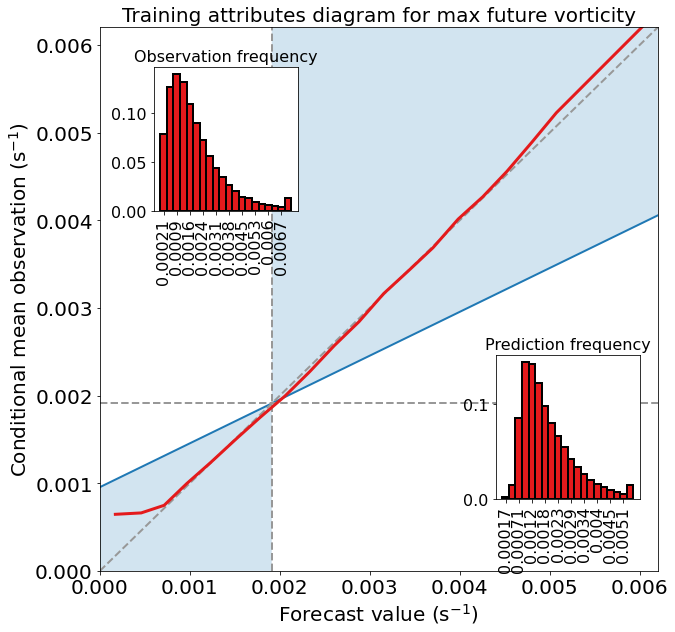



--------------------------------------------------


Validation MAE (mean absolute error) = 7.505e-04 s^-1
Validation MSE (mean squared error) = 1.024e-03 s^-2
Validation bias (mean signed error) = -9.007e-07 s^-1
Validation MAE skill score (improvement over climatology) = 0.316
Validation MSE skill score (improvement over climatology) = 0.540


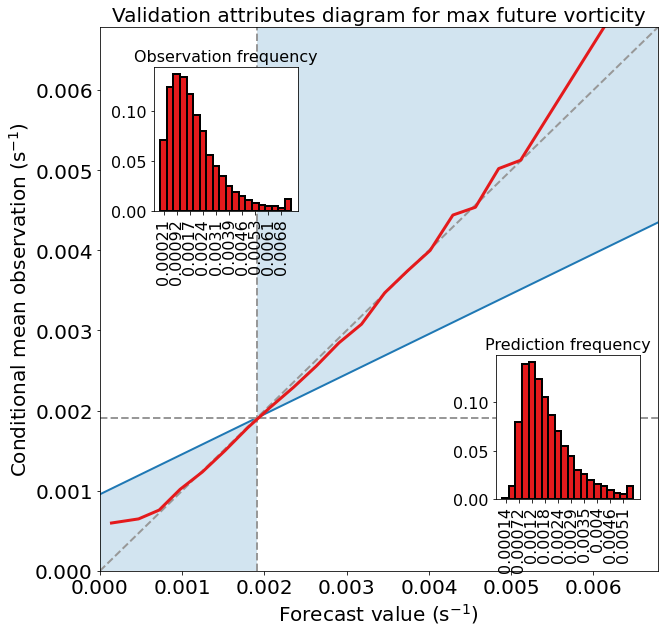

In [ ]:
training_predictions = linreg_model_object.predict(
    training_predictor_table.to_numpy()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    actual_values=training_target_table[utils.TARGET_NAME].values,
    predicted_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training'
)
print(MINOR_SEPARATOR_STRING)

validation_predictions = linreg_model_object.predict(
    validation_predictor_table.to_numpy()
)

_ = utils.evaluate_regression(
    actual_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation'
)

## Coefficients

- The next cell plots coefficients for the linear-regression model.
- **If predictor $x_j$ has a positive (negative) coefficient, the prediction increases (decreases) with $x_j$.**
- Keep in mind that all predictors have been normalized to the same scale ($z$-scores), so *generally* predictors with larger coefficients are more important.
- Also, note that every predictor is used (has a non-zero coefficient).

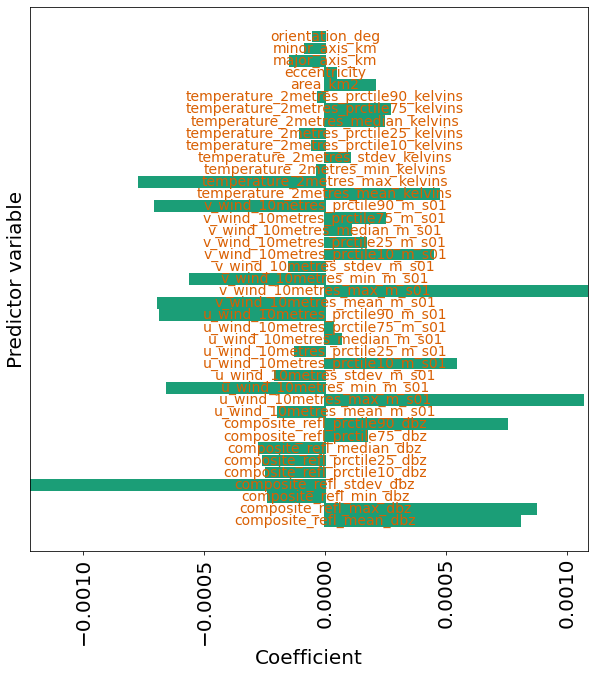

In [ ]:
utils.plot_model_coefficients(
    model_object=linreg_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# L$_1$ and L$_2$ regularization

## Theory

 - L$_1$ and L$_2$ are types of regularization.
 - **In general, regularization encourages a simpler model, thus discouraging overfitting.**
<br><br>
 - **L$_1$ and L$_2$ regularization encourage the model to learn smaller coefficients.**
 - **This is useful when there are many predictors**, because it is likely that some of these predictors have a weak causal relationship with the phenomenon.
 - Without regularization, the model will try to include every predictor, which could lead to overfitting.
 - **Regularization encourages the model to learn large coefficients for only a small number of predictors** (the really important ones).
<br><br>
 - **L$_1$ and L$_2$ regularization encourage smaller coefficients by adding penalties to the loss function.**
 - For linear regression, the loss function becomes:

<center>$\epsilon = \frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2 + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2 = \textrm{MSE} + \lambda_1 \sum\limits_{j = 1}^{M} \lvert \beta_j \rvert + \lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$</center>
<br>

 - The first term is just MSE (mean squared error).
 - The second term is the L$_1$ penalty.  $\lambda_1$ is the strength of the L$_1$ penalty, and $\sum\limits_{j = 1}^{M} \lvert \beta_j \rvert$ is the sum of absolute coefficients.
 - The third term is the L$_2$ penalty.  $\lambda_2$ is the strength of the L$_2$ penalty, and $\lambda_2 \sum\limits_{j = 1}^{M} \beta_j^2$ is the sum of squared coefficients.
<br><br>

 - **Both penalties encourage smaller coefficients, but the L$_1$ penalty encourages coefficients to become exactly zero.**
 - This is because the L$_1$ penalty does not involve squared coefficients.
 - For small coefficients the L$_2$ penalty is negligible (*e.g.*, a coefficient of $10^{-6}$ is squared to become $10^{-12}$), unless $\lambda_2$ is very large.
<br><br>
 - **Thus, the L$_1$ penalty is called the "lasso penalty"** (it throws a lasso around the most important predictors and keeps only these predictors).
 - **Meanwhile, the L$_2$ penalty is called the "ridge penalty".**

## Example with L$_2$: Training

- The next cell trains a linear-regression model with only the L$_2$ penalty.
- The regularization strength ($\lambda_2$) is $10^{5}$.
<br><br>
- Note that both training and validation performance get worse.
- Thus, $\lambda_2$ is too large.

Training MAE (mean absolute error) = 8.120e-04 s^-1
Training MSE (mean squared error) = 1.120e-03 s^-2
Training bias (mean signed error) = 3.212e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.279
Training MSE skill score (improvement over climatology) = 0.460


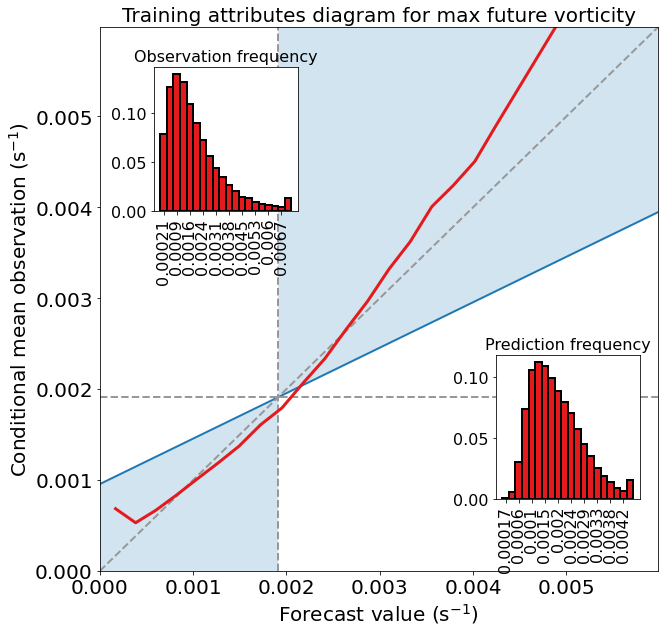



--------------------------------------------------


Validation MAE (mean absolute error) = 7.910e-04 s^-1
Validation MSE (mean squared error) = 1.092e-03 s^-2
Validation bias (mean signed error) = 7.027e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.279
Validation MSE skill score (improvement over climatology) = 0.477


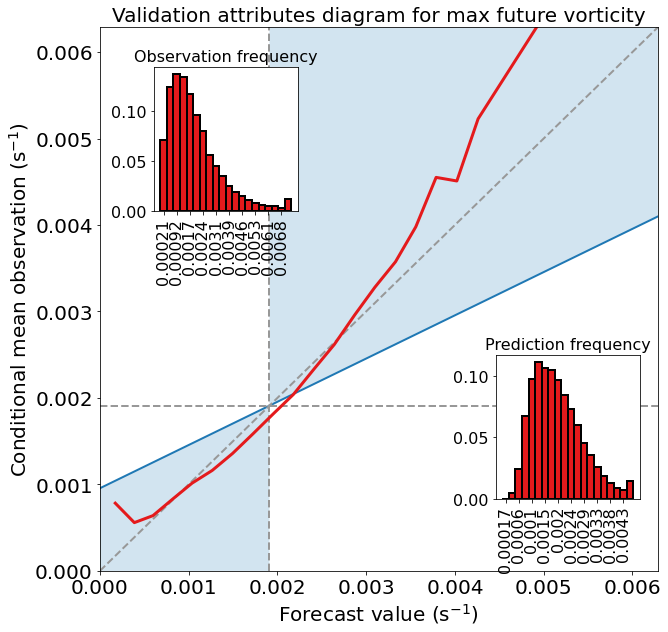

In [ ]:
linear_ridge_model_object = utils.setup_linear_regression(
    lambda1=0., lambda2=1e5
)

_ = utils.train_linear_regression(
    model_object=linear_ridge_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

training_predictions = linear_ridge_model_object.predict(
    training_predictor_table.to_numpy()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    actual_values=training_target_table[utils.TARGET_NAME].values,
    predicted_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training'
)
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_ridge_model_object.predict(
    validation_predictor_table.to_numpy()
)

_ = utils.evaluate_regression(
    actual_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation'
)

## Example with L$_2$: Coefficients

- The next cell plots coefficients for linear regression with only the L$_2$ penalty.
- Coefficients are generally an order of magnitude smaller than in the original model ($10^{-5}$ to $10^{-4}$, instead of $10^{-4}$ to $10^{-3}$).
- However, all coefficients are still non-zero.

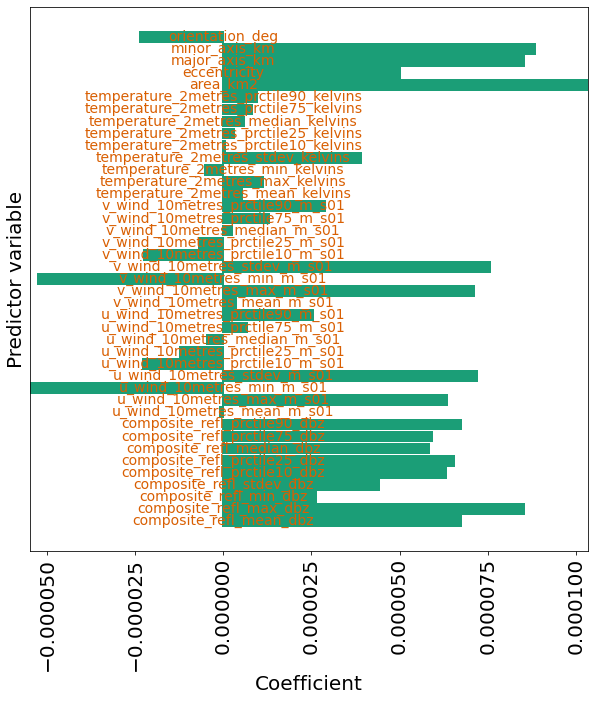

In [ ]:
utils.plot_model_coefficients(
    model_object=linear_ridge_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

## Example with L$_1$: Training

- The next cell trains a linear-regression model with only the L$_1$ penalty.
- The regularization strength ($\lambda_1$) is $10^{-5}$.
- Both training and validation performance get **a bit** worse than in the original model, which means that $\lambda_1$ is too large.
- However, L$_1$ regularization decreases performance less than L$_2$ regularization.

Training MAE (mean absolute error) = 7.893e-04 s^-1
Training MSE (mean squared error) = 1.081e-03 s^-2
Training bias (mean signed error) = 3.659e-19 s^-1
Training MAE skill score (improvement over climatology) = 0.299
Training MSE skill score (improvement over climatology) = 0.497


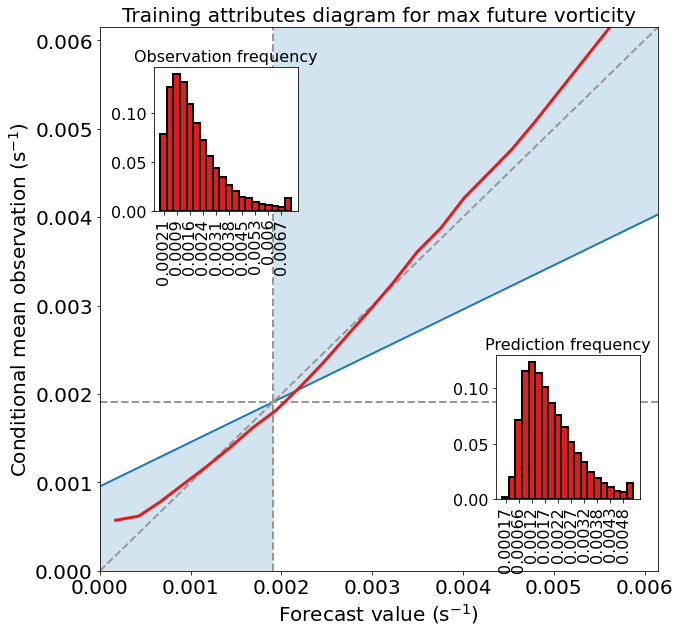



--------------------------------------------------


Validation MAE (mean absolute error) = 7.669e-04 s^-1
Validation MSE (mean squared error) = 1.050e-03 s^-2
Validation bias (mean signed error) = 1.086e-06 s^-1
Validation MAE skill score (improvement over climatology) = 0.301
Validation MSE skill score (improvement over climatology) = 0.516


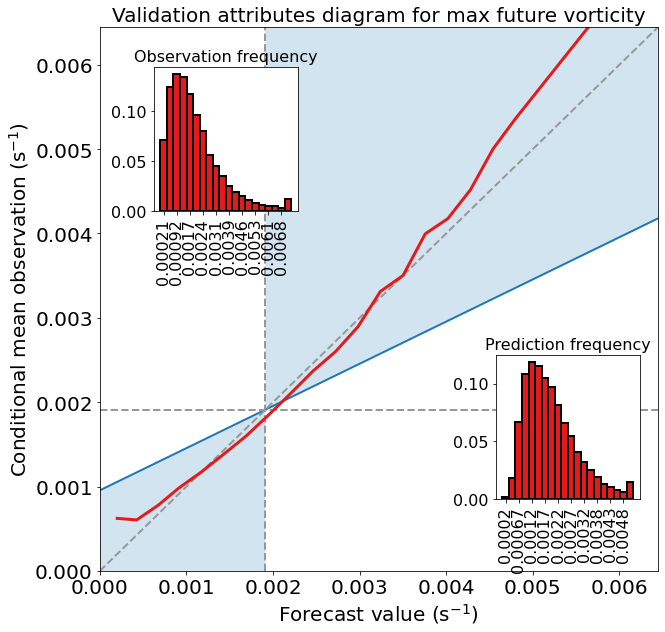

In [ ]:
linear_lasso_model_object = utils.setup_linear_regression(
    lambda1=1e-5, lambda2=0.
)

_ = utils.train_linear_regression(
    model_object=linear_lasso_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

training_predictions = linear_lasso_model_object.predict(
    training_predictor_table.to_numpy()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

_ = utils.evaluate_regression(
    actual_values=training_target_table[utils.TARGET_NAME].values,
    predicted_values=training_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='training'
)
print(MINOR_SEPARATOR_STRING)

validation_predictions = linear_lasso_model_object.predict(
    validation_predictor_table.to_numpy()
)

_ = utils.evaluate_regression(
    actual_values=validation_target_table[utils.TARGET_NAME].values,
    predicted_values=validation_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='validation'
)

## Example with L$_1$: Coefficients

- The next cell plots coefficients for linear regression with only the L$_1$ penalty.
- Non-zero coefficients are generally on the same order of magnitude as the original model ($\sim10^{-4}$).
- However, many coefficients (25 of 41) have been "zeroed out".
- This means that the model uses only 16 of the 41 predictors.

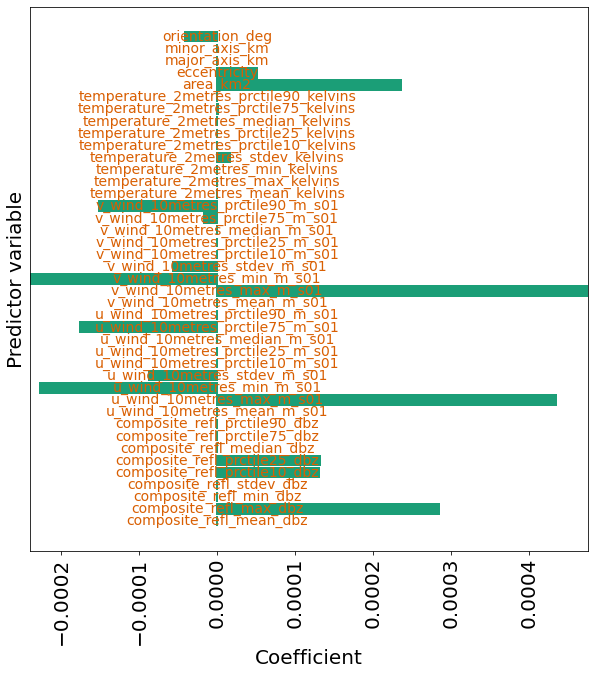

In [ ]:
utils.plot_model_coefficients(
    model_object=linear_lasso_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Tuning hyperparameters

The next few cells will show you how to conduct a "hyperparameter experiment".  **The steps in a hyperparameter experiment are as follows.**

 1. **Choose the values to be attempted.**  This is usually based on some *a priori* knowledge about how the model works.  The more expertise you have, the narrower you can make the range of attempted values.  In this case we attempt $\lambda_1 \in \lbrace 10^{-8}, 10^{-7.5}, 10^{-7}, 10^{-6.5}, 10^{-6}, 10^{-5.5}, 10^{-5}, 10^{-4.5}, 10^{-4} \rbrace$ and $\lambda_2 \in \lbrace 10^{-4}, 10^{-3.5}, 10^{-3}, 10^{-2.5}, 10^{-2}, 10^{-1.5}, 10^{-1}, 10^{-0.5}, 10^{0}, 10^{0.5}, 10^{1} \rbrace$.
<br><br>
 2. **Train a model with each combination of hyperparameters.**  In this case there are 9 values for $\lambda_1$ and 11 values for $\lambda_2$, so 99 combinations.  This is called a "grid search".  (Note: There are search methods other than grid search.  These become useful especially when the number of combinations is too large ("combinatiorial explosion"), which usually happens if you are experimenting with anymore than a few hyperparameters.  In this case you can do random search or beam search, use a genetic algorithm to evolve the hyperparameters, etc.  But we will stick with grid search in this module.)
<br><br>
 3. **Evaluate each model on the validation data.**
<br><br>
 4. **Find the model that performs best on the validation data.**  Again, there are many ways to define "best".  In this case we will select the model with the highest MAE skill score.

## Training

The next cell performs steps 1 and 2 of the hyperparameter experiment (defining the values to be attempted and training the models).

In [ ]:
lambda1_values = numpy.logspace(-8, -4, num=9)
lambda2_values = numpy.logspace(-4, 1, num=11)

num_lambda1 = len(lambda1_values)
num_lambda2 = len(lambda2_values)

validation_mae_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_rmse_matrix_s01 = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mae_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)
validation_mse_skill_matrix = numpy.full(
    (num_lambda1, num_lambda2), numpy.nan
)

mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

for i in range(num_lambda1):
    for j in range(num_lambda2):
        this_message_string = (
            'Training model with lasso coeff = 10^{0:.1f}, ridge coeff = '
            '10^{1:.1f}...'
        ).format(
            numpy.log10(lambda1_values[i]), numpy.log10(lambda2_values[j])
        )

        print(this_message_string)

        this_model_object = utils.setup_linear_regression(
            lambda1=lambda1_values[i], lambda2=lambda2_values[j]
        )

        _ = utils.train_linear_regression(
            model_object=this_model_object,
            training_predictor_table=training_predictor_table,
            training_target_table=training_target_table
        )

        these_validation_predictions = this_model_object.predict(
            validation_predictor_table.to_numpy()
        )

        this_evaluation_dict = utils.evaluate_regression(
            actual_values=validation_target_table[utils.TARGET_NAME].values,
            predicted_values=these_validation_predictions,
            mean_training_target_value=mean_training_target_value,
            verbose=False, create_plots=False
        )

        validation_mae_matrix_s01[i, j] = this_evaluation_dict[utils.MAE_KEY]
        validation_rmse_matrix_s01[i, j] = this_evaluation_dict[utils.RMSE_KEY]
        validation_mae_skill_matrix[i, j] = (
            this_evaluation_dict[utils.MAE_SKILL_SCORE_KEY]
        )
        validation_mse_skill_matrix[i, j] = (
            this_evaluation_dict[utils.MSE_SKILL_SCORE_KEY]
        )

Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-2.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-1.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^-0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.0...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^0.5...
Training model with lasso coeff = 10^-8.0, ridge coeff = 10^1.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-4.0...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.5...
Training model with lasso coeff = 10^-7.5, ridge coeff = 10^-3.0...
Training model with lasso coeff = 10^-7.5, ridge co

## Validation

The next cell performs step 3 of the hyperparameter experiment (evaluates each model on the validation data).

Text(0.5, 1.0, 'MSE skill score on validation data')

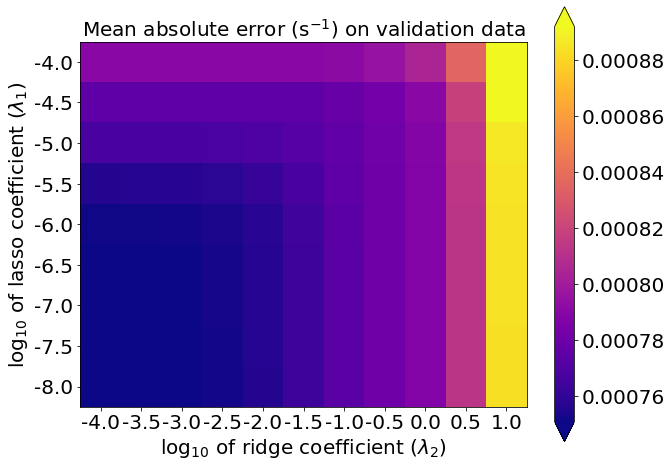

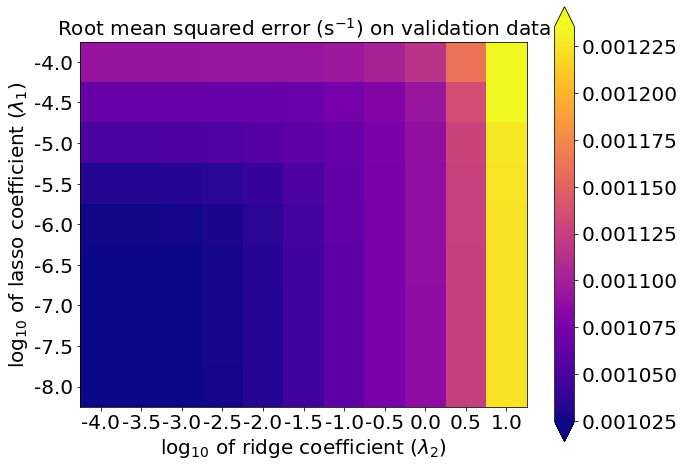

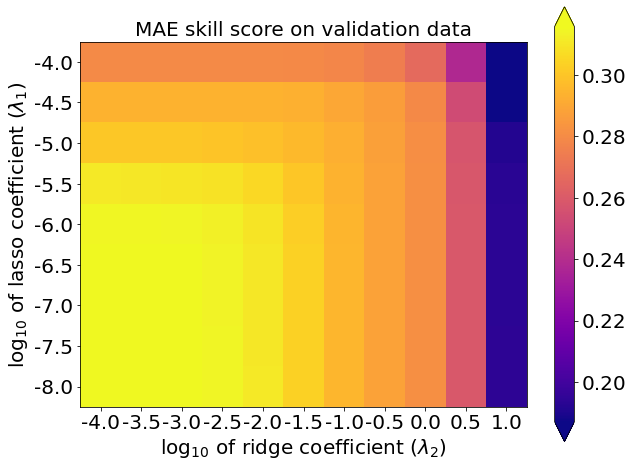

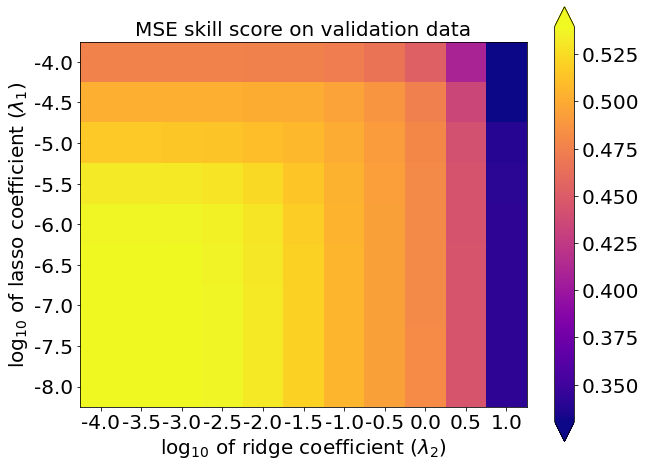

In [ ]:
utils.plot_scores_2d(
    score_matrix=validation_mae_matrix_s01,
    min_colour_value=numpy.percentile(validation_mae_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_mae_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Mean absolute error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_rmse_matrix_s01,
    min_colour_value=numpy.percentile(validation_rmse_matrix_s01, 1.),
    max_colour_value=numpy.percentile(validation_rmse_matrix_s01, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'Root mean squared error (s$^{-1}$) on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mae_skill_matrix,
    min_colour_value=numpy.percentile(validation_mae_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mae_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MAE skill score on validation data')

utils.plot_scores_2d(
    score_matrix=validation_mse_skill_matrix,
    min_colour_value=numpy.percentile(validation_mse_skill_matrix, 1.),
    max_colour_value=numpy.percentile(validation_mse_skill_matrix, 99.),
    x_tick_labels=numpy.log10(lambda2_values),
    y_tick_labels=numpy.log10(lambda1_values)
)

pyplot.xlabel(r'log$_{10}$ of ridge coefficient ($\lambda_2$)')
pyplot.ylabel(r'log$_{10}$ of lasso coefficient ($\lambda_1$)')
pyplot.title(r'MSE skill score on validation data')

## Selection

The next cell performs step 4 of the hyperparameter experiment (select model).

Best MAE skill score on validation data = 0.316 ... corresponding lasso coeff = 10^-6.5, ridge coeff = 10^-4.0
Testing MAE (mean absolute error) = 8.257e-04 s^-1
Testing MSE (mean squared error) = 1.189e-03 s^-2
Testing bias (mean signed error) = -8.985e-05 s^-1
Testing MAE skill score (improvement over climatology) = 0.338
Testing MSE skill score (improvement over climatology) = 0.555


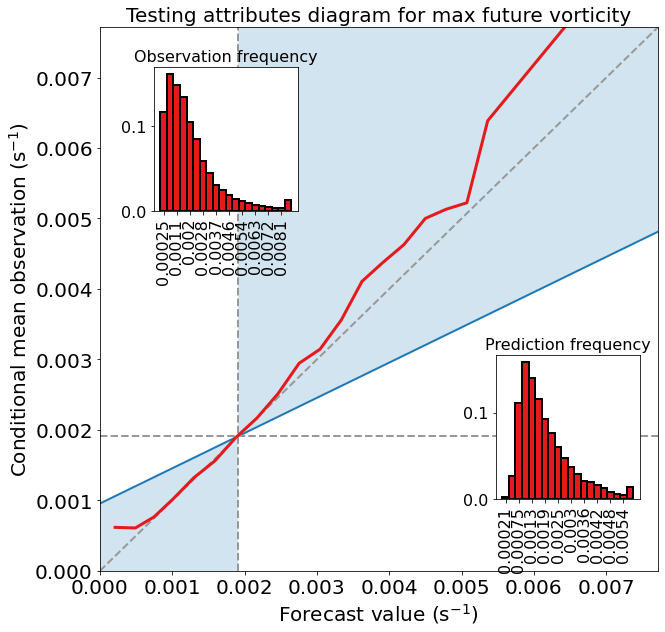

In [ ]:
best_linear_index = numpy.argmax(numpy.ravel(validation_mae_skill_matrix))

best_lambda1_index, best_lambda2_index = numpy.unravel_index(
    best_linear_index, (len(lambda1_values), len(lambda2_values))
)

best_lambda1 = lambda1_values[best_lambda1_index]
best_lambda2 = lambda2_values[best_lambda2_index]
best_validation_maess = numpy.max(validation_mae_skill_matrix)

message_string = (
    'Best MAE skill score on validation data = {0:.3f} ... corresponding '
    'lasso coeff = 10^{1:.1f}, ridge coeff = 10^{2:.1f}'
).format(
    best_validation_maess, numpy.log10(best_lambda1),
    numpy.log10(best_lambda2)
)

print(message_string)

final_model_object = utils.setup_linear_regression(
    lambda1=best_lambda1, lambda2=best_lambda2
)

_ = utils.train_linear_regression(
    model_object=final_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

testing_predictions = final_model_object.predict(
    testing_predictor_table.to_numpy()
)
mean_training_target_value = numpy.mean(
    training_target_table[utils.TARGET_NAME].values
)

this_evaluation_dict = utils.evaluate_regression(
    actual_values=testing_target_table[utils.TARGET_NAME].values,
    predicted_values=testing_predictions,
    mean_training_target_value=mean_training_target_value,
    dataset_name='testing'
)

## Exercise

- Based on the first hyperparameter experiment, write your own hyperparameter experiment (with a different set of $\lambda_1$ and $\lambda_2$ values).
- See if you can find a $\lambda_1$-$\lambda_2$ combo that works better on the validation data.
- If you find a combo that works better on the validation data, see if it also works better on the testing data.
- If not, you have overfit $\lambda_1$ and $\lambda_2$ to the validation data.

In [ ]:
# Insert code here.

# Binary classification

## Theory

 - **The rest of this module focuses on binary classification, rather than regression.**
 - "Regression" is the prediction of a real number (*e.g.*, above, where we predicted max future vorticity).
 - "Classification" is the prediction of a category (*e.g.*, low, medium, or high max future vorticity).
<br><br>
 - **In binary classification there are two categories.**
 - Thus, prediction takes the form of answering a **yes-or-no question.**
 - We will use the same target variable (max future vorticity), except we will binarize it.
 - The problem will be predicting whether or not max future vorticity exceeds a threshold.

## <font color='red'>Binarize target variable (required)</font>

- The next cell binarizes the target variable (max future vorticity in s$^{-1}$).
- **Binarization turns each value into a 0 (no) or 1 (yes), based on whether or not future vorticity reaches a threshold.**
- This is necessary because the next ML model (logistic regression) does classification, not regression.

In [ ]:
binarization_threshold = utils.get_binarization_threshold(
    tabular_file_names=training_file_names, percentile_level=90.
)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[1030:1050]
)

message_string = (
    'Real-numbered target values for a few training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.BINARIZED_TARGET_NAME].values[1030:1050]
)

message_string = (
    '\nBinarized target values for the same training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

## Exercise

- If you want to use another percentile (instead of the 90$^{\textrm{th}}$) for binarization, feel free to do so here.
- For example, if you want to work with a non-rare event, you could use something like the 50$^{\textrm{th}}$ percentile.
- If you want to work with an even rarer event, you could use the 99$^{\textrm{th}}$ percentile.

In [ ]:
# Insert code here.

# Logistic regression

## Theory

- **Logistic regression is basically linear regression for binary classification.**
- Recall the equation for linear regression:
<center>$\hat{y} = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$</center>
<br>

- Only the left-hand side is changed for logistic regression:
<center>$\textrm{ln}(\frac{\hat{y}}{1 - \hat{y}}) = \beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j$</center>
<br>

- This can be rewritten as:
<center>$\hat{y} = \frac{\textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}{1 + \textrm{exp}(\beta_0 + \sum\limits_{j = 1}^{M} \beta_j x_j)}$</center>
<br>

- **This forces $\hat{y}$ to have limits of $\left[0, 1\right]$, so it can be interpreted as a probability.**
- The weights ($\beta_0$ and $\beta_j$) are trained to minimize cross-entropy, rather than mean squared error.
<center>$\epsilon = -\frac{1}{N} \sum\limits_{i = 1}^{N} \left[ y_i\textrm{ log}_2(\hat{y}_i) + (1 - y_i)\textrm{ log}_2(1 - \hat{y}_i) \right]$</center>
<br>

- $\hat{y}_i$ = forecast probability for $i^{\textrm{th}}$ example.
  - This is the probability of the "event" (class = 1).
  - In our case, this is probability that max future vorticity $\ge 3.850 \times 10^{-3}\textrm{ s}^{-1}$.
- $y_i$ = true label for $i^{\textrm{th}}$ example (0 or 1)
- $N$ = number of training examples
- $\epsilon$ = cross-entropy
<br><br>

- **Cross-entropy varies from $\left[0, \infty\right)$ and is negatively oriented (lower is better).**
- Cross-entropy comes from information theory and is proportional to the number of bits needed to describe the difference between the two distributions (predictions and labels).
- When the distributions are equivalent ($\hat{y}_i = 1.0$ for all positive examples and $\hat{y}_i = 0.0$ for all negative examples), the number of bits is zero, so cross-entropy is zero.
<br>

- As for linear regression, the derivatives of model coefficients with respect to cross-entropy are as follows.
<center>$\frac{\partial \epsilon}{\partial \beta_0} = \frac{2}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)$</center>
<br>
<center>$\frac{\partial \epsilon}{\partial \beta_j} = \frac{2}{N} \sum\limits_{i = 1}^{N} x_{ij} (\hat{y}_i - y_i)$</center>
<br>

- **As for linear regression, the weights ($\beta_0$ and $\beta_j$) are adjusted during training via gradient descent:**
<center>$\beta_0 \leftarrow \beta_0 - \alpha \frac{\partial \epsilon}{\partial \beta_0}$</center>
<br>
<center>$\beta_j \leftarrow \beta_j - \alpha \frac{\partial \epsilon}{\partial \beta_j}$</center>

## Training

The next cell trains a basic logistic-regression model (with default hyperparameters) to predict the label for each storm (strong future vorticity or not).

In [ ]:
plain_log_model_object = utils.setup_logistic_regression(
    lambda1=0., lambda2=0.
)

_ = utils.train_logistic_regression(
    model_object=plain_log_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

## Evaluation

The next cell evaluates the model we just trained, on both training and validation data.

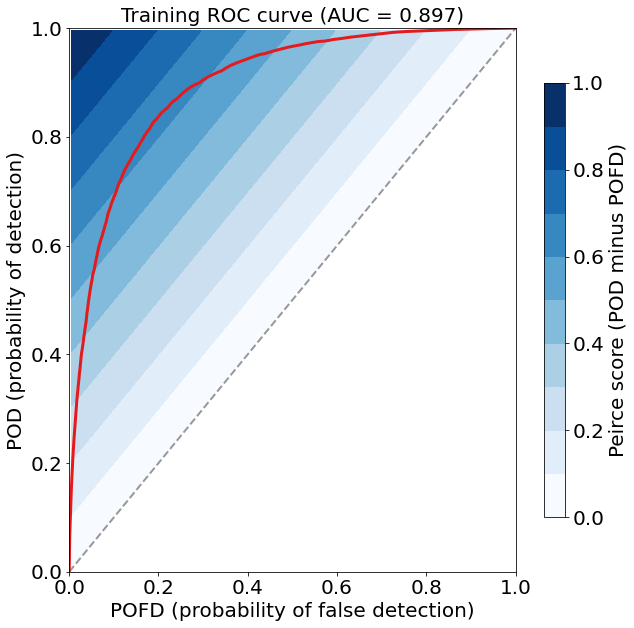

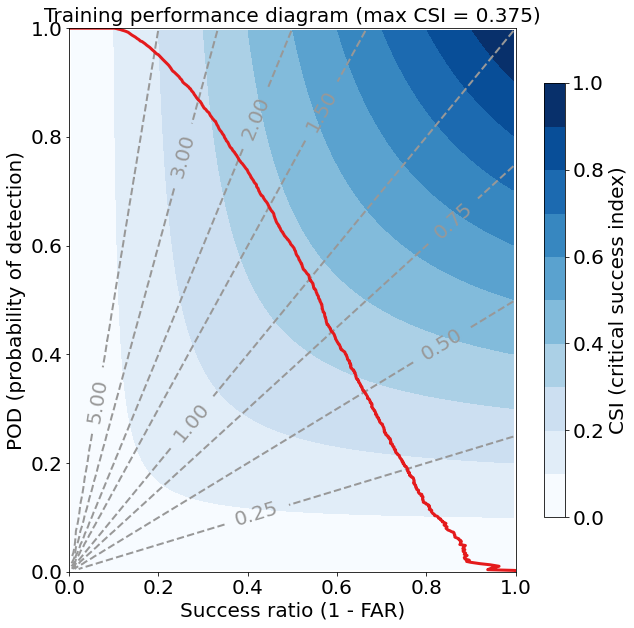

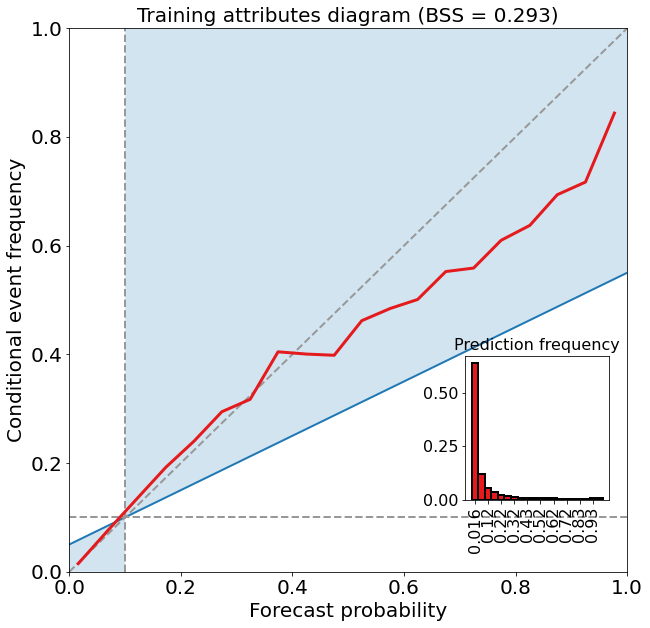

Training max Peirce score (POD - POFD) = 0.639
Training AUC (area under ROC curve) = 0.897
Training max CSI (critical success index) = 0.375
Training Brier score = 0.064
Training Brier skill score (improvement over climatology) = 0.293


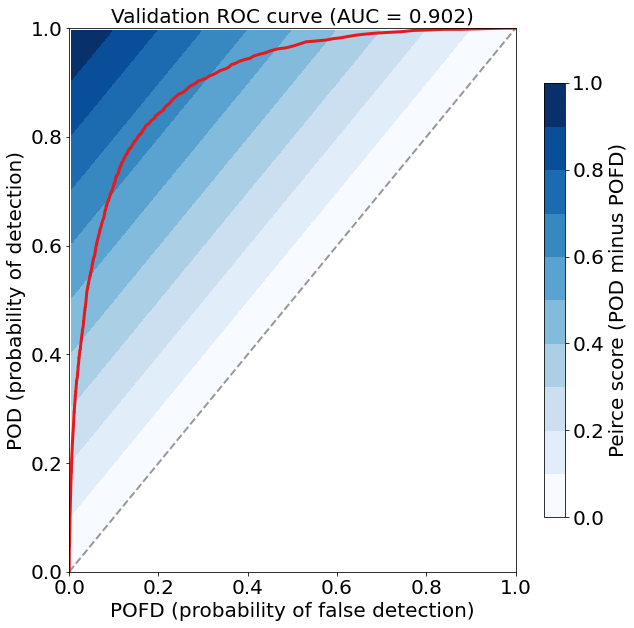

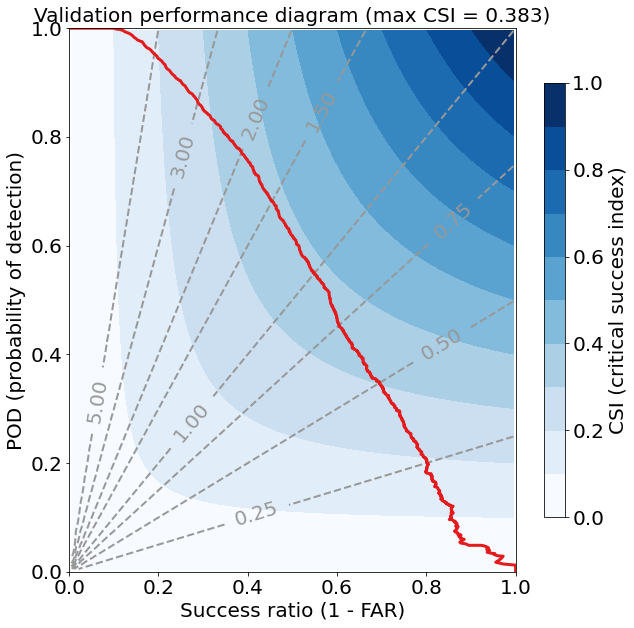

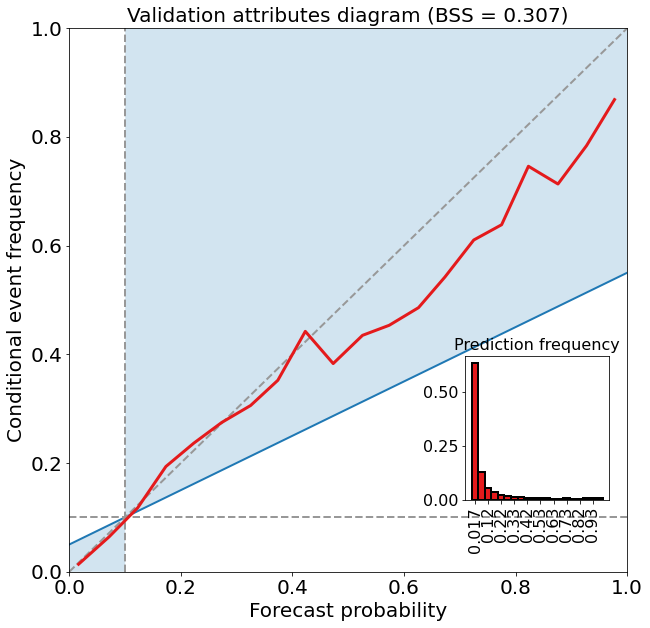

Validation max Peirce score (POD - POFD) = 0.649
Validation AUC (area under ROC curve) = 0.902
Validation max CSI (critical success index) = 0.383
Validation Brier score = 0.063
Validation Brier skill score (improvement over climatology) = 0.307


In [ ]:
training_probabilities = plain_log_model_object.predict_proba(
    training_predictor_table.to_numpy()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=
    training_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training'
)

validation_probabilities = plain_log_model_object.predict_proba(
    validation_predictor_table.to_numpy()
)[:, 1]

_ = utils.eval_binary_classifn(
    observed_labels=
    validation_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation'
)

## Coefficients

 - The next cell plots coefficients for the logistic-regression model.
 - Positive (negative) coefficients mean that probability increases (decreases) with the predictor variable.
 - Again, predictors have been normalized to the same scale ($z$-scores), so generally predictors with larger coefficients are more important.

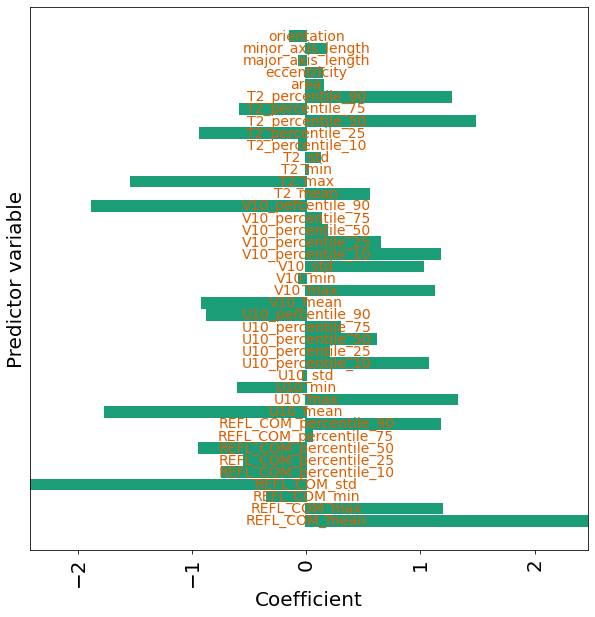

In [ ]:
utils.plot_model_coefficients(
    model_object=plain_log_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

# Logistic regression with L$_1$ and L$_2$

## Training

 - The next cell trains a logistic-regression model with both L$_1$ and L$_2$ regularization.
 - As for linear regression, you could do a hyperparameter experiment to find the best $\lambda_1$ and $\lambda_2$ for logistic regression.
<br><br>
 - **People often say that their model is "ridge regression"** (with L$_2$ regularization), **"lasso regression"** (with L$_1$ regularization), **or "elastic-net regression"** (with both).
 - **However, this is not descriptive enough.**
 - As you can see, L$_1$ and L$_2$ regularization can be applied to different base models (linear and logistic regression are just two of many).

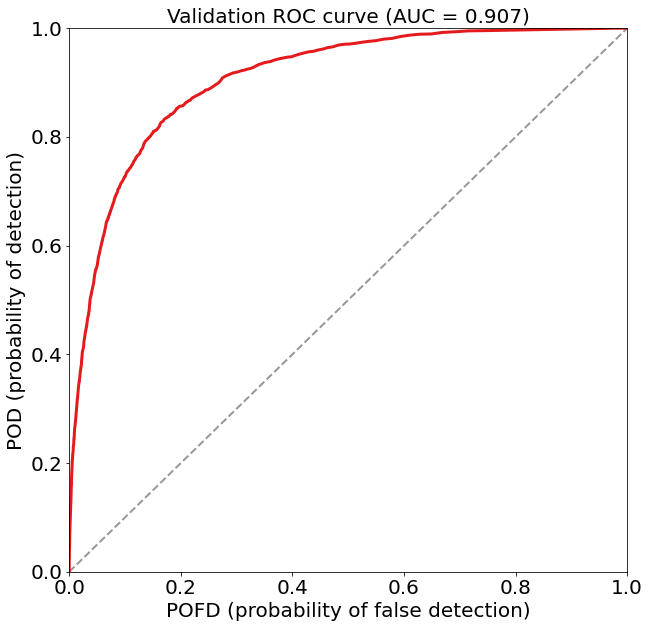

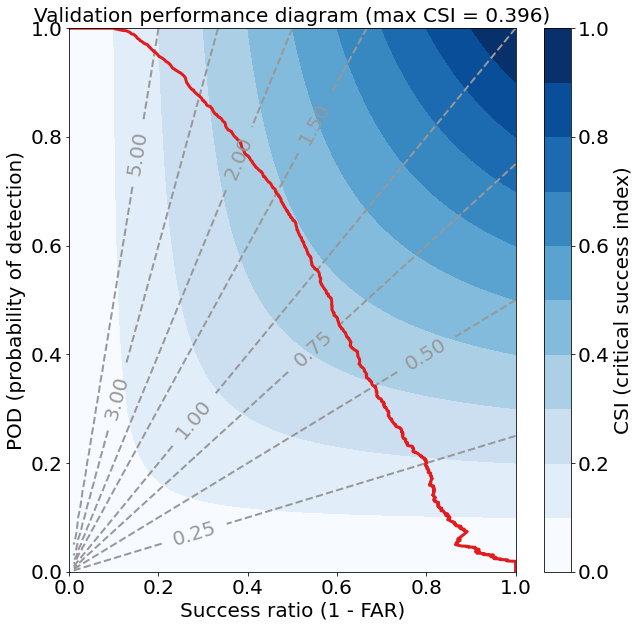

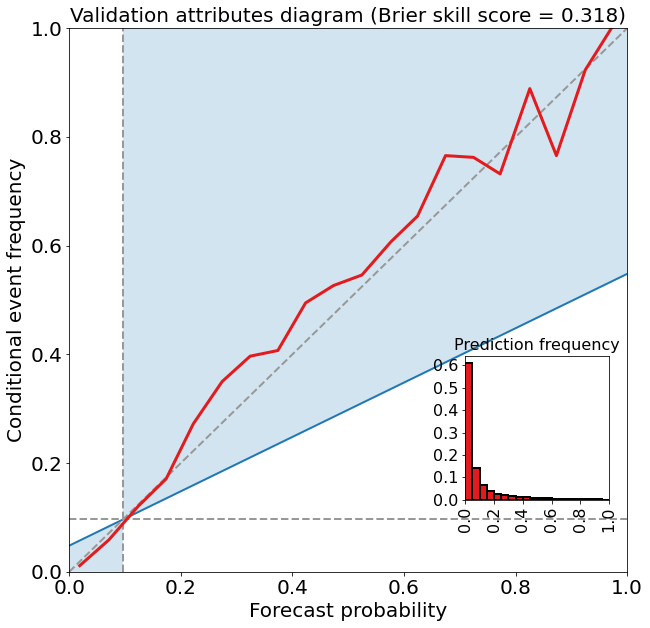

Validation max Peirce score (POD - POFD) = 0.662
Validation AUC (area under ROC curve) = 0.907
Validation max CSI (critical success index) = 0.396
Validation Brier score = 0.062
Validation Brier skill score (improvement over climatology) = 0.318


In [ ]:
logistic_en_model_object = utils.setup_logistic_regression(
    lambda1=1e-3, lambda2=1e-3
)

_ = utils.train_logistic_regression(
    model_object=logistic_en_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

validation_probabilities = logistic_en_model_object.predict_proba(
    validation_predictor_table.to_numpy()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=
    validation_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation'
)

## Coefficients

- The next cell plots coefficients for the logistic-regression model with both penalties.
- Many coefficients are zero, and the non-zero ones are an order of magnitude smaller than for the original model.

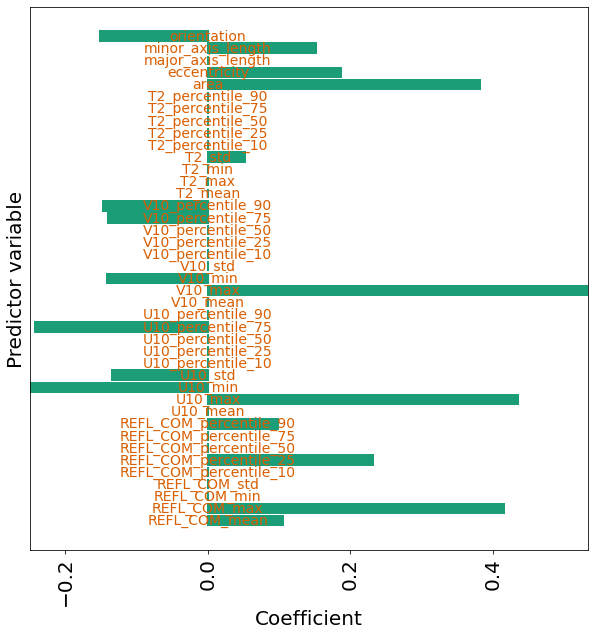

In [ ]:
utils.plot_model_coefficients(
    model_object=logistic_en_model_object,
    predictor_names=list(training_predictor_table)
)

pyplot.show()

## Exercise

- Train a logistic-regression model with your own $\lambda_1$ and $\lambda_2$ values.
- Investigate performance on the training and validation data.
- Plot coefficients.

In [ ]:
# Insert code here.

# <font color='red'>Isotonic regression (Ryan needs to add stuff)</font>